# Final activity: Analyzing gene expression of Acute Leukaemia Patients

For the final exercise, you will use what you have learnt so far to analyze a gene expression dataset from acute leukaemia patients given an outline of the steps to take. This DNA microarray dataset was initially published in Golub et al. ["Molecular Classification of Cancer: Class Discovery and Class Prediction by Gene Expression Monitoring"](https://www.science.org/doi/10.1126/science.286.5439.531?url_ver=Z39.88-2003&rfr_id=ori:rid:crossref.org&rfr_dat=cr_pub%20%200pubmed)

### About the Dataset:

The dataset contains the gene expression levels of 7129 genes in cells from both the bone marrow and peripheral blood of patients diagnosed with acute myeloid leukemia (AML) and acute lymphoblastic leukemia (ALL). This dataset was utilized initially for the classification of patients into AML and ALL categories. 

There are **two datasets** containing the initial (training, 38 samples) and independent (test, 34 samples) datasets used in the paper. These datasets contain measurements corresponding to ALL and AML samples from Bone Marrow and Peripheral Blood. Intensity values have been re-scaled such that overall intensities for each chip are equivalent. A total of 7129 gene features were measured. 


### Dataset Location:

The dataset is provided as three .csv files from the [course github repository](https://github.com/TheDeanLab/Intro-to-Python-2024/tree/main/activities/gene_expression) 

1. `actual.csv` - this gives the actual disease status of each sample, either ALL or AML
2. `data_set_ALL_AML_train.csv` - this is the training data, 7129 genes x 38 samples
3. `data_set_ALL_AML_independent.csv` - this is the testing data, 7129 genes x 34 samples


### Overview of Analysis Steps:

We will use this dataset to conduct a typical analysis for DNA microarray and bulk sequencing. This involves:

1. **Preprocessing the data** 
    - so that the data is suitable for computation
    
2. **Identifying the most informative gene features** 
    - if a gene has 0-value it is 100% not informative

3. **Exploratory analysis** 

    - use dimensionality reduction to look for patterns, check problems, e.g. does the data support ALL and AML separation?

4. **What genes determine AML or ALL**:
    1. hypothesis testing between AML and ALL group
    2. machine learning classifiers and feature importance

## Step 0. Load in the data

You will first write code to read in all 3 csv's using pandas library. Then print the shape of the tables you have read in. 

Something might look wrong - Can you figure it out? 

In [1]:
import pandas as pd 

# Write code to load the training dataset (data_set_ALL_AML_train.csv)
pd_train = pd.read_csv('gene_expression/data_set_ALL_AML_train.csv')

# Write code to load the testing dataset (data_set_ALL_AML_independent.csv)
pd_test = pd.read_csv('gene_expression/data_set_ALL_AML_independent.csv')

# Write code to load in the disease status of patients
pd_label = pd.read_csv('gene_expression/actual.csv')

## Step 1. Clean and Preprocess the data

### a) Deleting extra non-numeric columns in train and test tables

After reading in the datasets, you will notice that the shape of the table is wrong. For train we expect 39 patients i.e. 39 columns. For test we expect 35 patients, i.e. 35 columns. We appear to have exactly double that. 

In [2]:
# Write a print statement to display the first few entries of train or test table. 
# What is the column names of the extra columns that are not numerical?

print(pd_train)

# 'call' columns are the ones we need to drop. 

                                       Gene Description Gene Accession Number  \
0                   AFFX-BioB-5_at (endogenous control)        AFFX-BioB-5_at   
1                   AFFX-BioB-M_at (endogenous control)        AFFX-BioB-M_at   
2                   AFFX-BioB-3_at (endogenous control)        AFFX-BioB-3_at   
3                   AFFX-BioC-5_at (endogenous control)        AFFX-BioC-5_at   
4                   AFFX-BioC-3_at (endogenous control)        AFFX-BioC-3_at   
...                                                 ...                   ...   
7124  PTGER3 Prostaglandin E receptor 3 (subtype EP3...             X83863_at   
7125  HMG2 High-mobility group (nonhistone chromosom...             Z17240_at   
7126      RB1 Retinoblastoma 1 (including osteosarcoma)           L49218_f_at   
7127  GB DEF = Glycophorin Sta (type A) exons 3 and ...           M71243_f_at   
7128                          GB DEF = mRNA (clone 1A7)           Z78285_f_at   

        1 call    2 call.1 

Write code to remove the extra columns to generate an only numeric table for train and test. **HINT**: [pandas.DataFrame.drop](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.drop.html)

In [3]:
# Remove call columns in training dataset
pd_train = pd_train.drop([col for col in pd_train.columns if 'call' in col], axis=1) # drop colums

# Remove call columns in testing dataset
pd_test = pd_test.drop([col for col in pd_test.columns if 'call' in col], axis=1) # drop colums

print(pd_train.shape)
print(pd_test.shape)

# NOTE: there are still 2 extra columns at the start for gene name information.

(7129, 40)
(7129, 36)


### b) Cross-index gene expression and disease status for each patient

Check the number of patients with disease status. You will see that it is more than the number of patients in train or test. Oh noes..... 

We can only do interesting analysis when we have both the gene expression AND the disease status. 

The patient id in the train and test tables are given by the column names. 
You need to write code so that each patient that has gene expression info has the disease status designation.

**Expected Outcome**:
patients with both gene expression and disease status. You should have:
1. two variables, `y_label_train` and `y_label_test` with the disease status of patients in train and test
2. two numpy arrays, `X_train` and `X_test` with the gene expression of the same patients, size of array is n_patients x n_genes i.e. columns = genes
3. a variable, `gene_description` to store gene description
4. a variable, `gene_accession_number` to store gene accession number

**HINT**: You can use the table approach or the Python loop approach
- transpose the table and use pd.merge
OR
- use for loops and numpy np.unique and if-else control 

In [4]:
# 1. Find the disease label i.e. ALL or AML for patients in train data. 
# Save the expression in X_train variable, save their disease label as y_label_train

import numpy as np 

# I'm going to write a for loop, noting that this is integer in pd_label 
print(pd_label)
patient_train = pd_train.columns[2:]
y_label_train = []

for patient in patient_train:
    patient_disease = pd_label.loc[pd_label['patient'].values == int(patient), 'cancer']
    y_label_train.append(patient_disease)

"""
we have our arrays.
"""
X_train = pd_train.iloc[:,2:].values.astype(np.float32).T # .T is transpose
y_label_train = np.hstack(y_label_train)

print(X_train.shape, y_label_train.shape)

    patient cancer
0         1    ALL
1         2    ALL
2         3    ALL
3         4    ALL
4         5    ALL
..      ...    ...
67       68    ALL
68       69    ALL
69       70    ALL
70       71    ALL
71       72    ALL

[72 rows x 2 columns]
(38, 7129) (38,)


In [5]:
# 2. Find the disease label i.e. ALL or AML for patients in test data. 
# Save the expression in X_test variable, save their disease label as y_label_test

patient_test = pd_test.columns[2:]
y_label_test = []

for patient in patient_test:
    patient_disease = pd_label.loc[pd_label['patient'].values == int(patient), 'cancer']
    y_label_test.append(patient_disease)

"""
we have our arrays.
"""
X_test = pd_test.iloc[:,2:].values.astype(np.float32).T
y_label_test = np.hstack(y_label_test)

print(X_test.shape, y_label_test.shape)

(34, 7129) (34,)


In [6]:
# 3. create a numpy variable to store gene description
gene_description = pd_train['Gene Description'].values

In [7]:
# 4. create a numpy variable to store gene accession number
gene_accession_number = pd_train['Gene Accession Number'].values

## Step 2. Pruning the data, retaining the most informative gene features

Use the following code snippet with your `X_train` array to visualize a heatmap of the gene expression. 

What is the problem here? 

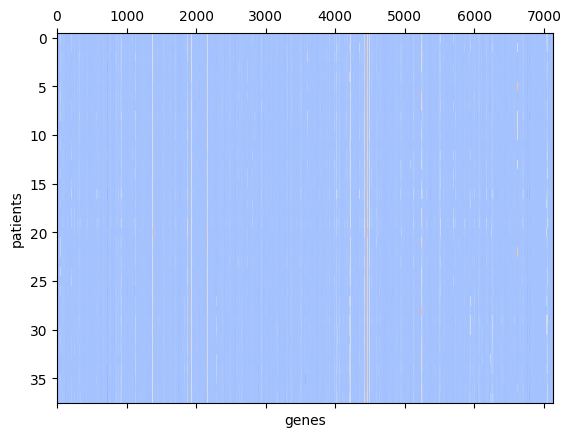

In [8]:
import pylab as plt 

fig, ax = plt.subplots()
ax.matshow(X_train, cmap='coolwarm')
ax.set_xlabel('genes')
ax.set_ylabel('patients')
ax.set_aspect('auto')
plt.show()

Let's also make histograms of the first two genes, to check their distribution.

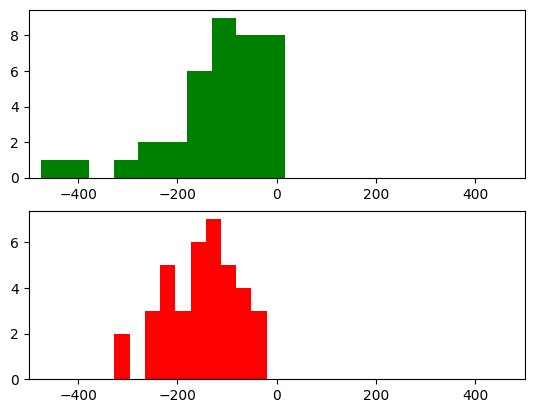

In [9]:
gene1 =  X_train[:,0] # write code to get this from X_train
gene2 =  X_train[:,1] # write code to get this from X_train

fig, ax = plt.subplots(nrows=2, ncols=1)
ax[0].hist(gene1, bins=10, color='g')
ax[0].set_xlim([-500,500])
ax[1].hist(gene2, bins=10, color='r')
ax[1].set_xlim([-500,500])
plt.show()

Did you see that the x-values of the histograms are very different? - try different genes to convince yourself. 

**Data normalization is essential for analysis**:

It's very common for genes to have different range of values. One reason is because the expression is not measured on an absolute scale. 

What this means however is that its difficult to compare across genes i.e. use the multi-dimensional gene signature to compare patients. This is why we need to perform preprocessing to normalize the data. 

The preprocessing is done on the combined train and test expression to apply the same steps to both for fairness.

### Overview of Preprocessing Steps:

1. create a variable `X` that is the merged array of `X_train` and `X_test`
2. write function to remove any genes and associated gene ids information that was not measured for a patient i.e. is np.nan 
3. write function to remove any genes and associated gene ids information that has zero-variance (i.e. they are the same value for each patient). **HINT:** `sklearn.feature_selection.VarianceThreshold`
4. write function to standard scale the remaining genes. **HINT:** `sklearn.preprocessing.StandardScaler`

In [10]:
# 1. make a variable X that merges X_train and X_test. 

X = np.vstack([X_train, X_test]) # np.vstack stacks two arrays along the first axis. 

In [11]:
# 2. Write a function to apply to X to remove any genes (i.e. columns) where a patient did not provide a value. i.e. was np.nan
# Make sure to save the index and apply it also to `gene_description` and `gene_accession_number`.  
# Output should be a variable X_filter

X_nan = np.isnan(X) # find all nans
X_nan_sum = X_nan.sum(axis=0) # sums along rows for each column
keep_genes_bool = X_nan_sum == 0 # no nans

X_filter = X[:,keep_genes_bool].copy()
gene_description_filter = gene_description[keep_genes_bool].copy()
gene_accession_number = gene_accession_number[keep_genes_bool].copy()

print(X.shape, X_filter.shape) # no genes are dropped. 

(72, 7129) (72, 7129)


In [12]:
# 3. Write a function to apply to X_filter, to removes genes (i.e. columns) which are zero-variance across patients. 
# Output should write over X_filter 
# HINT: use sklearn.feature_selection.VarianceThreshold

from sklearn.feature_selection import VarianceThreshold

VarianceThreshold_selector = VarianceThreshold(threshold=0.0)
# fit it 
VarianceThreshold_selector.fit(X_filter)
# apply 
X_filter = VarianceThreshold_selector.transform(X_filter)

# apply to other variables.
filter_index = VarianceThreshold_selector.get_support()
gene_description_filter = gene_description[filter_index].copy()
gene_accession_number = gene_accession_number[filter_index].copy()

print(X_filter.shape, gene_description_filter.shape) # no genes are dropped. 

(72, 7129) (7129,)


In [13]:
# 4. Write a function to apply to X_filter, to standard scale gene expression 
# Output should be a variable X_stdscale  
# Each gene should now be zero mean and one variance. **Bonus:** write a function to check this.  
# HINT: use sklearn.preprocessing.StandardScaler

from sklearn.preprocessing import StandardScaler

X_stdscale = StandardScaler().fit_transform(X_filter)

all_means = np.mean(X_stdscale, axis=0) # close to 0.
all_stds = np.std(X_stdscale, axis=0) # all 1's 

print(all_means.shape, all_means)
print('-------')
print(all_stds.shape, all_stds)

(7129,) [-4.9670539e-09 -8.2784233e-09 -1.3245477e-08 ...  3.3113692e-09
  3.3113692e-09 -9.9341078e-09]
-------
(7129,) [1.         0.99999994 1.         ... 1.         1.         1.        ]


## Step 3. Exploratory analysis

Before we do anything fancy, we always want to check whether the data is 'good enough'. 

Here, we want to check whether using the gene expression, there is any evidence we might be able to separate the two cancers, ALL and AML. 

A quick and cheerful way to do this is to apply dimensionality reduction. There are of course many algorithms for performing dimensionality reduction with different pros and cons. 

A good rule of thumb is to start with PCA, principal components analysis. Why? - it is the easiest to interpret. If the data separates under PCA, you can bet you can classify it without anything fancy. If PCA doesn't work well, you may try e.g. UMAP, t-SNE, PacMAP which are nonlinear dimensionality reduction algorithms

### Principal Components Analysis (PCA)

PCA is an essential algorithm for any budding statistician or data scientist. I suggest watching a YouTube video or google search to understand more. 

Intuitively, your n-dimensional data lives in an n-dimensional space, such that your data places each patient at n-dimensional coordinates. What PCA does is it fits an n-dimensiona ellipsoid across all patients. Then it finds a rotation of the data to display it onto the top K major axes of this ellipsoid. 

We can use PCA through `sklearn.decomposition.PCA` 

In [14]:
# 1. apply sklearn.decomposition.PCA to fit a PCA model with n_components=2 to your X_stdscale

from sklearn.decomposition import PCA

pca_model = PCA(n_components=2)
pca_model.fit(X_stdscale)

pca_coords = pca_model.transform(X_stdscale)

In [15]:
# 2. Merge your disease label variables into a single variable. This should be the same number of patients as X_stdscale 

y_labels = np.hstack([y_label_train, y_label_test]) # hstack merges flat arrays, and columns (axis=1)

In [16]:
# 3. use sklearn.preprocessing.LabelEncoder to map your labels into integers

from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(y_labels)

y_labels_int = le.transform(y_labels) # get the integer

print(y_labels_int)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1
 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


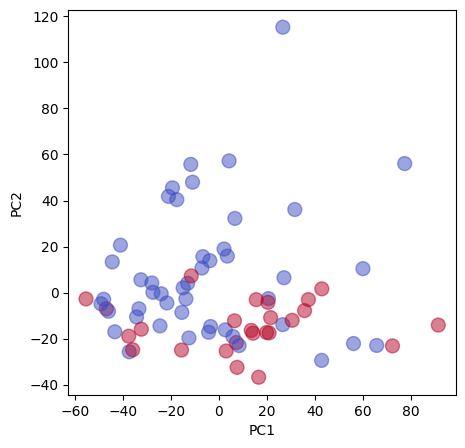

[0.14921574 0.09446172]


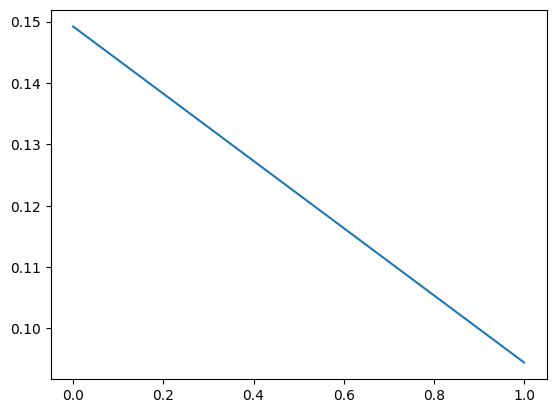

In [17]:
# 4. use matplotlib to scatter plot the pca outputs, coloring points by disease status. 

import pylab as plt 

# 1 is red and 0 is blue under the 'coolwarm' color scheme 
plt.figure(figsize=(5,5))
plt.scatter(pca_coords[:,0], 
             pca_coords[:,1],
            s=100, 
            c=y_labels_int,
           cmap='coolwarm',
           alpha=0.5)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

# you can see the 2nd pca axis can separate the data


# We can also plot how much variance is explained by each PC. 
explained_variance = pca_model.explained_variance_ratio_

print(explained_variance)

plt.figure()
plt.plot(explained_variance)
plt.show()

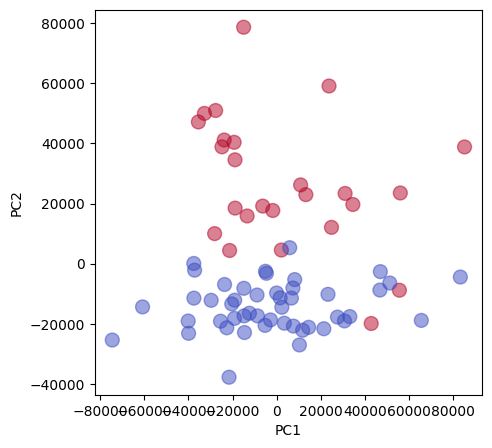

In [18]:
# 5. (Extension) apply PCA but now using the un-normalized data i.e. X_filter or X. What do you find? 

pca_model_unnorm = PCA(n_components=2)
pca_model_unnorm.fit(X)

pca_coords_unnorm = pca_model_unnorm.transform(X)

# 1 is red and 0 is blue under the 'coolwarm' color scheme 
plt.figure(figsize=(5,5))
plt.scatter(pca_coords_unnorm[:,0], 
             pca_coords_unnorm[:,1],
            s=100, 
            c=y_labels_int,
           cmap='coolwarm',
           alpha=0.5)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

### (Extension): Try different dimensionality reduction techniques

Scikit-learn has a gallery of dimensionality reduction techniques. https://scikit-learn.org/stable/modules/manifold.html
Try applying some of these in the same manner and see what is the result.

If you are feeling really ambitious, check out dimensionality reduction techniques from other sources e.g. UMAP (from [umap-learn](https://umap-learn.readthedocs.io/en/latest/) and PacMAP (from https://github.com/YingfanWang/PaCMAP)



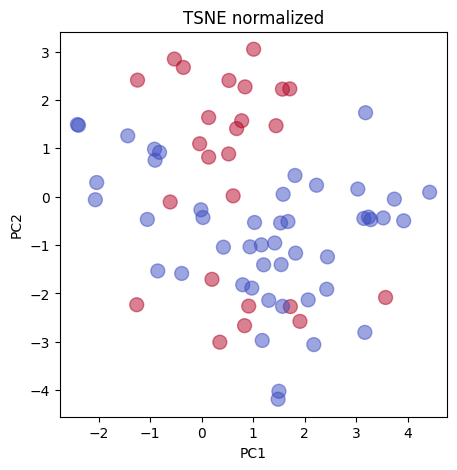

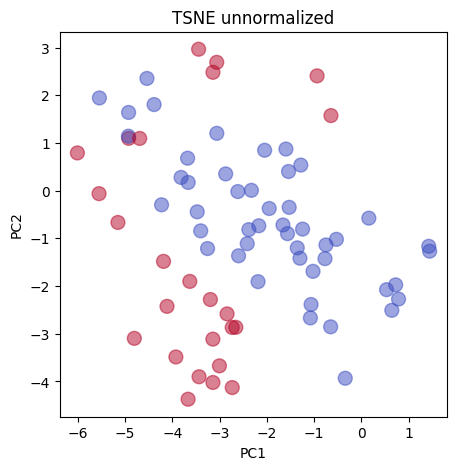

In [19]:
# Have fun :D
from sklearn.manifold import TSNE

tsne_model = TSNE(n_components=2, random_state=42)
tsne_coords = tsne_model.fit_transform(X_stdscale)

# 1 is red and 0 is blue under the 'coolwarm' color scheme 
plt.figure(figsize=(5,5))
plt.title('TSNE normalized')
plt.scatter(tsne_coords[:,0], 
             tsne_coords[:,1],
            s=100, 
            c=y_labels_int,
           cmap='coolwarm',
           alpha=0.5)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()


tsne_coords = tsne_model.fit_transform(X)

# 1 is red and 0 is blue under the 'coolwarm' color scheme 
plt.figure(figsize=(5,5))
plt.title('TSNE unnormalized')
plt.scatter(tsne_coords[:,0], 
             tsne_coords[:,1],
            s=100, 
            c=y_labels_int,
           cmap='coolwarm',
           alpha=0.5)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

## Step 4. Finding what genes determine Leukaemia type

From the PCA plots you should see that there was separation between the different leukaemia types.

With this data, generally our question is to find the driving genes between these two conditions. We generally use two criteria:

1. what are the genes with best classification performance (use ML classifiers)
2. what are the genes that are most statistically differential (hypothesis tests)

### a). Train a machine learning classifer and find driving genes (Support Vector Machine with L1 feature selection)

This method requires the data to be split into training (model fitting) and testing (model evaluation). The basic idea is that if we use all the data then the model will overfit, as generally the machine learning model can have many more model parameters than the data diversity. 

For this exercise we will use a classical machine learning classifier called a [support vector machine (SVM)](https://en.wikipedia.org/wiki/Support_vector_machine). These are easy to understand, easy to use, give great robust performance, and well implemented within scikit-learn. Here we will use a linear SVM which will try to fit a best plane of separation. 

Usually ML classifiers are applied directly on the scaled data i.e. not after PCA. 

### Overview of Steps
1. split `X_stdscale` back into train and test i.e. create two variables `X_train_stdscale`, `X_test_stdcale`
2. apply the fitted labelencoder to transform `y_label_train` and `y_label_test` to be integer giving two variables, `y_label_train_int`, `y_label_test_int`
3. compute the number of ALL and AML cases - are they balanced? i.e. is it 50-50 occurrence? 
4. use `sklearn.svm.LinearSVC` to fit a model to `X_train_stdscale` and `y_label_train_int`. Check what argument you need to set in order to account for the label imbalance. **HINT:** c.f.  refer to the example of 
https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
5. Evaluate the fitted model using `X_test_stdscale` and `y_label_test_int` by computing and visualizing the confusion matrix. **HINT:** c.f. the same example, https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
6. If you are happy with your classifier, follow the SVM example in https://scikit-learn.org/stable/auto_examples/feature_selection/plot_feature_selection.html#sphx-glr-auto-examples-feature-selection-plot-feature-selection-py to extract the SVM weights as a measure of feature importance to rank your genes with decreasing importance.

# ALL in train:,  27
# AML in train:,  11
                                       gene_description svm importance
460   Liver mRNA for interferon-gamma inducing facto...       0.202575
6809                     DDH1 Dihydrodiol dehydrogenase       0.088412
6538                                  Epb72 gene exon 1       0.083223
2300                             ACTN2 Actinin alpha 2        0.080188
4846                                              Zyxin       0.077643
...                                                 ...            ...
2376   Cadherin-associated protein-related (cap-r) mRNA            0.0
2375                                       LOR Loricrin            0.0
2374                 DHODH Dihydroorotate dehydrogenase            0.0
2373    NOS3 Nitric oxide synthase 3 (endothelial cell)            0.0
7128                          GB DEF = mRNA (clone 1A7)            0.0

[7129 rows x 2 columns]


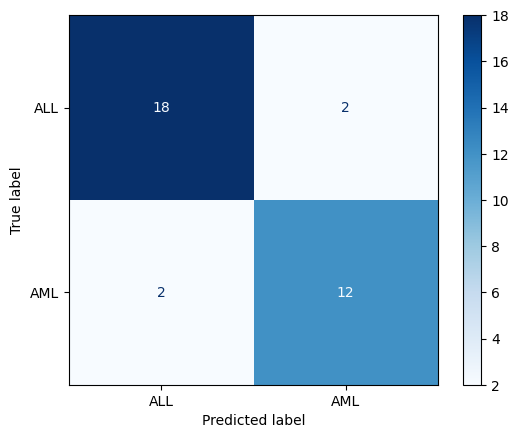

In [51]:
# 1. normally we use something like sklearn.model_selection.train_test_split. Here the train and test is actually given 

X_train_stdscale = X_stdscale[:len(X_train)]
X_test_stdscale = X_stdscale[-len(X_test):]

# 2. labelencoder
y_label_train_int = le.transform(y_label_train)
y_label_test_int = le.transform(y_label_test)

# 3. compute number of ALL and AML cases - not balanced!. 
ALL_num_train = (y_label_train=='ALL').sum()
AML_num_train = (y_label_train=='AML').sum()

print('# ALL in train:, ', ALL_num_train)
print('# AML in train:, ', AML_num_train)

# 4. fit linear SVM
from sklearn.svm import LinearSVC
from sklearn.svm import SVC

svc = LinearSVC(penalty='l1', class_weight='balanced', random_state=0, max_iter=10000)
svc.fit(X_train_stdscale, y_label_train_int)

# 5. evaluate the fitting SVM 
from sklearn.metrics import ConfusionMatrixDisplay

class_names = le.classes_

disp = ConfusionMatrixDisplay.from_estimator(
                                svc,
                                X_test_stdscale,
                                y_label_test_int,
                                display_labels=class_names,
                                cmap=plt.cm.Blues,
                                normalize=None)

# 6. extract the weight importance of genes. 
svm_weights = np.abs(svc.coef_).sum(axis=0)
svm_weights /= svm_weights.sum()

# create a new table to show this with the genes 
gene_importance_table = pd.DataFrame(np.vstack([gene_description_filter, 
                                                svm_weights]).T, 
                                               columns=['gene_description','svm importance'])

# print out in descending order
print(gene_importance_table.sort_values(by='svm importance', ascending=False))

### b). Hypothesis testing of individual gene expression between AML and ALL

Machine learning classifiers are sensitive to the number of genes and which genes are used as features (columns). Alternative method is to try to use statistics to analyze. 

Here we are going to do the basic statistics approach using t-test and fdr correction. We won't cover other necessary steps usually doing before statistics testing such as batch correction. In practice, you would use dedicated packages e.g. Seurat in R or scanpy in Python that integrate this functionality for gene expression analysis. 


### Overview of Steps
1. Split your combined normalized dataset into AML and ALL patients i.e. have a `X_stdscale_AML` and `X_stdscale_ALL` array.  
2. Use a for loop and the independent t-test, `scipy.stats.ttest_ind` to compute the test statistic and p-value for each gene.
3. Convert the results into a table whose columns are `['Gene Accession Number', 'T_Value', 'P_Value']`
4. Install `statsmodels` library, (see its [website](https://www.statsmodels.org/stable/index.html) for install instructions)
5. Use `statsmodels.stats.multitest.fdrcorrection` on the computed p-values to get corrected p-values.
6. Set a significance-level e.g. $p<0.05$, apply this to filter on corrected p-values and produce a sorted list of significant genes sorted in ascending order by p-value (remember: small the p-value, the more significant
7. Generate histograms of expresssion in AML and ALL patients for top ranked genes. Plot AML and ALL histogram on the same axis to check that the statistical test has worked (i.e. two histograms should be different with minimal overlap the smaller the p-value!).  
8. (Extension:) Make a combined heatmap with AML and ALL patients visualizing the significant genes. Display a sorted heatmap such where all AML patients are first, then all ALL patients.

(25, 7129) (47, 7129)
                                  Gene Accession Number    T_Value   P_Value  \
4846                                              Zyxin  10.923121       0.0   
1833        CD33 CD33 antigen (differentiation antigen)   8.980219       0.0   
4195             PRG1 Proteoglycan 1; secretory granule    9.01962       0.0   
2287             DF D component of complement (adipsin)   8.561285       0.0   
6040   APLP2 Amyloid beta (A4) precursor-like protein 2   8.432427       0.0   
...                                                 ...        ...       ...   
1120  SDC2 Syndecan 2 (heparan sulfate proteoglycan ...  -2.760298  0.007366   
3028                     ZNF174 Zinc finger protein 174   2.758094  0.007411   
1955                  Cell adhesion protein (SQM1) mRNA  -2.757842  0.007416   
1851                    ACPP Acid phosphatase; prostate   2.755579  0.007463   
2029  GBP1 Guanylate binding protein 1; interferon-i...    -2.7542  0.007491   

           fdr  


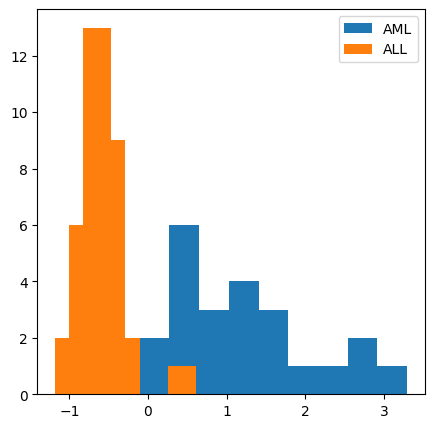

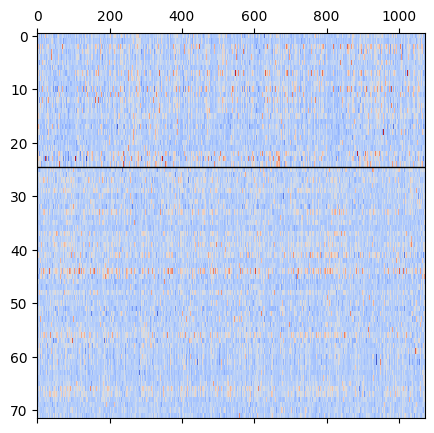

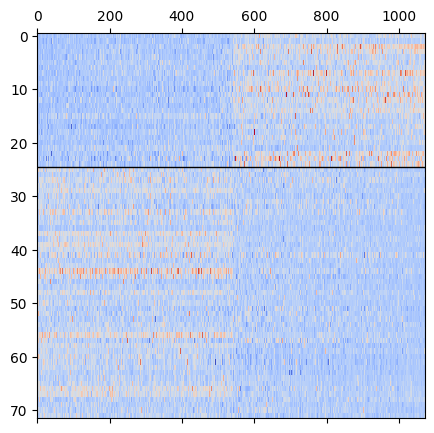

In [34]:
# 1. splitting into AML and ALL
X_stdscale_AML = X_stdscale[y_labels=='AML'].copy()
X_stdscale_ALL = X_stdscale[y_labels=='ALL'].copy()

print(X_stdscale_AML.shape, X_stdscale_ALL.shape)

# 2. ttest with loop
from scipy.stats import ttest_ind

test_outputs = []

for gene_ii in np.arange(len(gene_description_filter)):
    
    gene_AML = X_stdscale_AML[:,gene_ii]
    gene_ALL = X_stdscale_ALL[:,gene_ii]
    
    ttest, pval = ttest_ind(gene_AML, gene_ALL)
    test_outputs.append([ttest,pval])
    
test_outputs = np.array(test_outputs) # make into array

# 3. convert to table. 
ttest_table = pd.DataFrame(np.vstack([gene_description_filter, 
                                     test_outputs[:,0], 
                                     test_outputs[:,1]]).T, 
                          columns=['Gene Accession Number', 'T_Value', 'P_Value'])

# 4. install statsmodels

# 5. apply fdr correction from statsmodels, and create a new table column to store output 
from statsmodels.stats.multitest import fdrcorrection


ttest_table['fdr'] = fdrcorrection(ttest_table['P_Value'])[1]


# 6. Set 0.05 significance level -> subset the table to get only those genes that meet this criteria
alpha = 0.05 

significant_genes = ttest_table.loc[ttest_table['fdr'].values<=alpha]
significant_genes = significant_genes.sort_values(by='fdr', ascending=True)

print(significant_genes)

# 7. Generate histograms of top genes -> check the top 1. 
AML_top_gene = X_stdscale_AML[:,gene_description_filter==significant_genes.iloc[0]['Gene Accession Number']]
ALL_top_gene = X_stdscale_ALL[:,gene_description_filter==significant_genes.iloc[0]['Gene Accession Number']]

plt.figure(figsize=(5,5))
plt.hist(AML_top_gene, bins=10, label='AML')
plt.hist(ALL_top_gene, bins=10, label='ALL')
plt.legend(loc='best')
plt.show()


# 8. Make a combined heatmap of the significant genes for both patients. 
AML_patients_significant = X_stdscale_AML[:,ttest_table['fdr'].values<=alpha]
ALL_patients_significant = X_stdscale_ALL[:,ttest_table['fdr'].values<=alpha]
fdr_significant = ttest_table['fdr'].values[ttest_table['fdr'].values<=alpha]

mean_AML = np.mean(AML_patients_significant, axis=0)
combined_significant = np.vstack([AML_patients_significant, 
                                  ALL_patients_significant])


# combine together and use plt.matshow
fig, ax = plt.subplots(figsize=(5,5))
ax.matshow(combined_significant, cmap='coolwarm')
ax.hlines(len(AML_patients_significant)-0.5, 0, len(fdr_significant), color='k', lw=1) # add a horizontal line to delineate
ax.set_aspect('auto')
ax.set_xlim([0,len(fdr_significant)])
plt.show()

# visualize again but sorting the columns according to mean expression (lowest genes in AML first, then highest.)
fig, ax = plt.subplots(figsize=(5,5))
ax.matshow(combined_significant[:,np.argsort(mean_AML)], cmap='coolwarm')
ax.hlines(len(AML_patients_significant)-0.5, 0, len(fdr_significant), color='k', lw=1) # add a horizontal line to delineate
ax.set_aspect('auto')
ax.set_xlim([0,len(fdr_significant)])
plt.show()
